# Lezione 16

In [ ]:
from urllib.request import urlopen

from antlr4.tree.Tree import ParseTreeWalker

from liblet import ANTLR, Stack

# Ancora sulle grammatiche

## Ricorsione e precedenza

ANTLR contente di trattare (senza particolari accorgimenti da parte dell'utente) grammatiche con regole ricorsive della forma $A\to A \alpha$ (o $A\to \alpha A$) e di "risolvere" (a patto di ordinare opportunamente le alternative) l'ambiguità che potrebbe derivare da regole del tipo $A\to \alpha_1 | \alpha_2$.

### Operatori aritmetici

Iniziamo dal caso paradigmatico della solita grammatica $E\to E + E | E * E | t$. La parola `1 + 2 * 3` ammette due parsing diversi, uno che "corrisponde" alla precedenza intesa $1+(2*3)$  e l'altro a quella "errata" $(1+2)*3$.

In [ ]:
expr = '1 + 2 * 3'

In [ ]:
# la grammatica che porta alla precedenza corretta

MulProd = ANTLR(r"""
grammar MulProd; ignoblebug: expr;
 
expr: expr '*' expr
    | expr '+' expr
    | NUM
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

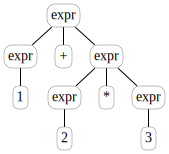

In [ ]:
multprod_parse_tree = MulProd.tree(expr, 'expr', True)
multprod_parse_tree

In [ ]:
# invertendo le alternative per somma e prodotto, si ha la precedenza errata

MulProdWrong = ANTLR(r"""
grammar MulPordWrong; ignoblebug: expr;
 
expr: expr '+' expr
    | expr '*' expr
    | NUM
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

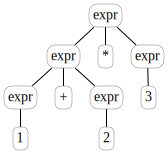

In [ ]:
MulProdWrong.tree(expr, 'expr', True)

### Dangling else

Un altro caso in cui l'ambiguità entra in gioco è quello degli statement `if-else`; il segmento di codice 

In [ ]:
source = ' if e0 then if e1 then i0 else i1'

può infatti essere interpretato (ossia può condurre a un albero di parsing) sia come

```bash
if e0 then (if e1 then i0 else i1)
```

che è il modo usuale nei linguaggi di programmazione più comuni, che come

```bash
if e0 then (if e1 then i0) else i1
```

In [ ]:
# definiamo un lexer per le parti e… ed i… e per l'usuale whitespace

LEXER = r"""
ISTR: 'i' [0-9]* ;
EXPR: 'e' [0-9]* ;
WS: [ \t\n\r]+ -> skip ;
"""

In [ ]:
# una grammatica che conduce all'associazione dell'else all'if più vicino

IfElse = ANTLR(r"""
grammar IfElse;

stat:   'if' EXPR 'then' stat
    |   'if' EXPR 'then' stat 'else' stat
    |   ISTR
    ;
    
""" + LEXER)

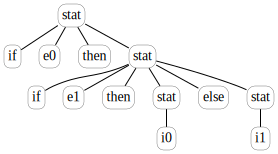

In [ ]:
IfElse.tree(source, 'stat', True)

In [ ]:
# di nuovo, invertendo l'ordine si ottiene un parse "errato"

IfElseWrong = ANTLR(r"""
grammar IfElseWrong;

stat:   'if' EXPR 'then' stat 'else' stat
    |   'if' EXPR 'then' stat
    |   ISTR
    ;
    
""" + LEXER)

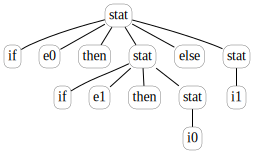

In [ ]:
IfElseWrong.tree(source, 'stat', True)

In [ ]:
# può essere più comoda da ricordare la forma con l'operatore regolare ?

IfElse = ANTLR(r"""
grammar IfElse;

stat:   'if' EXPR 'then' stat ('else' stat)?
    |   ISTR
    ;
    
""" + LEXER)

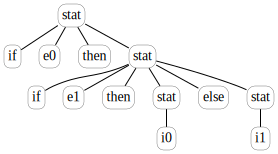

In [ ]:
IfElse.tree(source, 'stat', True)

## Bug e bizzarrie

In [ ]:
def parse(grammar_fragment, start, text):
  try:
    return ANTLR(fr"""grammar Expr;
      {grammar_fragment}
      POW : '^';
      PLUS : '+';
      ID : [a-zA-Z]+;
      INT : [0-9]+;
      WS : [ \t\n\r] -> skip;
    """).tree(text, start, simple = True)
  except Exception as e:
    print(e)

In [ ]:
# la prima regola ha problemi con la ricorsione

parse(
r"""

e : e PLUS e | INT;

""", 'e', '1')

line 1:1 no viable alternative at input '<EOF>'


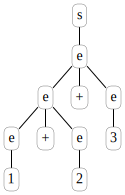

In [ ]:
# basta aggiungere una regola…

parse(
r"""

s : e;

e : e PLUS e | INT;

""", 's', '1 + 2 + 3')

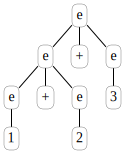

In [ ]:
# … eventualmente costruendo l'albero dalla precedente prima regola

parse(
r"""

s : e;

e : e PLUS e | INT;

""", 'e', '1 + 2 + 3')

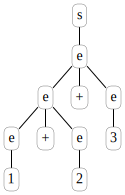

In [ ]:
# attenzione ai match parziali

parse(
r"""

s : e;

e : e PLUS e | INT;

""", 's', '1 + 2 + 3 4')

In [ ]:
# il token predefinito EOF può risolvere il problema

# https://github.com/antlr/antlr4/blob/master/doc/parser-rules.md#start-rules-and-eof

parse(
r"""

s : e EOF;

e : e PLUS e | INT;

""", 's', '1 + 2 + 3 4')

line 1:10 extraneous input '4' expecting <EOF>


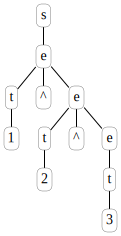

In [ ]:
# la associatività a destra va risolta "a mano"

parse(
r"""

s : e EOF;

e : t POW e | t;

t : INT;

""", 's', '1 ^ 2 ^ 3')

## Qualche buon esempio

In [ ]:
def get(url):
  return urlopen(url).read().decode('utf-8')

In [ ]:
Arithmetic = ANTLR(get('https://raw.githubusercontent.com/antlr/grammars-v4/master/arithmetic/arithmetic.g4'))

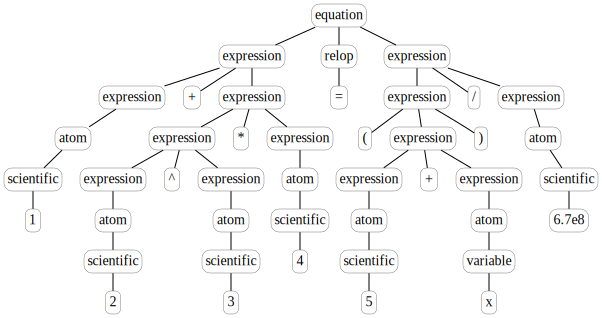

In [ ]:
Arithmetic.tree('1 + 2 ^ 3 * 4 = ( 5 + x ) / 6.7e8', 'equation', True)

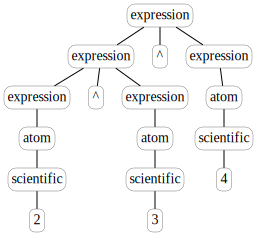

In [ ]:
# l'associatività è sbagliata! (perché?)

Arithmetic.tree('2 ^ 3 ^ 4', 'expression', True)

In [ ]:
Calc = ANTLR(get('https://raw.githubusercontent.com/antlr/grammars-v4/master/calculator/calculator.g4'))

In [ ]:
Calc.print_grammar()

  1:	/*
  2:	BSD License
  3:	
  4:	Copyright (c) 2013, Tom Everett
  5:	All rights reserved.
  6:	
  7:	Redistribution and use in source and binary forms, with or without
  8:	modification, are permitted provided that the following conditions
  9:	are met:
 10:	
 11:	1. Redistributions of source code must retain the above copyright
 12:	   notice, this list of conditions and the following disclaimer.
 13:	2. Redistributions in binary form must reproduce the above copyright
 14:	   notice, this list of conditions and the following disclaimer in the
 15:	   documentation and/or other materials provided with the distribution.
 16:	3. Neither the name of Tom Everett nor the names of its contributors
 17:	   may be used to endorse or promote products derived from this software
 18:	   without specific prior written permission.
 19:	
 20:	THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
 21:	"AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
 22:	LIMITED TO

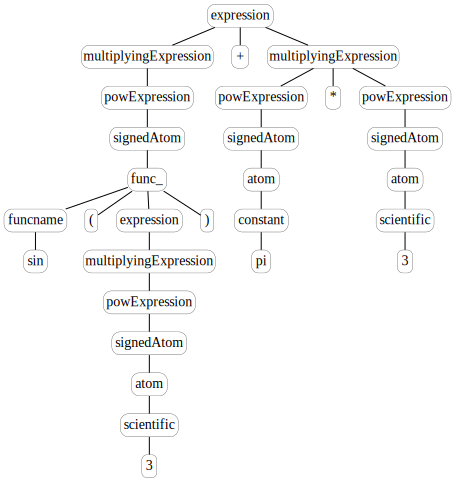

In [ ]:
Calc.tree('sin(3) + pi * 3', 'expression', True)

In [ ]:
Cymbol = ANTLR(get('http://media.pragprog.com/titles/tpantlr2/code/examples/Cymbol.g4').replace('type', 'type_').replace('file', 'file_'))

In [ ]:
Cymbol.print_grammar()

  1:	/** Simple statically-type_d programming language with functions and variables
  2:	 *  taken from "Language Implementation Patterns" book.
  3:	 */
  4:	grammar Cymbol;
  5:	
  6:	file_:   (functionDecl | varDecl)+ ;
  7:	
  8:	varDecl
  9:	    :   type_ ID ('=' expr)? ';'
 10:	    ;
 11:	type_:   'float' | 'int' | 'void' ; // user-defined type_s
 12:	
 13:	functionDecl
 14:	    :   type_ ID '(' formalParameters? ')' block // "void f(int x) {...}"
 15:	    ;
 16:	formalParameters
 17:	    :   formalParameter (',' formalParameter)*
 18:	    ;
 19:	formalParameter
 20:	    :   type_ ID
 21:	    ;
 22:	
 23:	block:  '{' stat* '}' ;   // possibly empty statement block
 24:	stat:   block
 25:	    |   varDecl
 26:	    |   'if' expr 'then' stat ('else' stat)?
 27:	    |   'return' expr? ';' 
 28:	    |   expr '=' expr ';' // assignment
 29:	    |   expr ';'          // func call
 30:	    ;
 31:	
 32:	expr:   ID '(' exprList? ')'    // func call like f(), f(x), f(1,2)
 33:	    |   ID '['

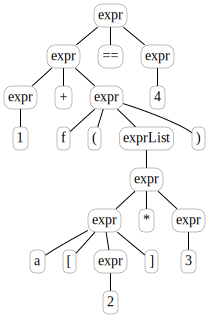

In [ ]:
Cymbol.tree('1 + f(a[2] * 3) == 4', 'expr', True)

# Ancora su listener e visitor 

Consideriamo un semplice linguaggio di programmazione in cui ci sia una istruzione per riga e le istruzioni possano essere espressioni aritmetiche o assegnamenti di variabile.

In [ ]:
LabeledExpr = ANTLR.load('LabeledExpr.g') # salvata in L15
LabeledExpr.print_grammar()

  1:	
  2:	grammar LabeledExpr; // rename to distinguish from Expr.g4
  3:	
  4:	prog:   stat+ ;
  5:	
  6:	stat:   expr NEWLINE                # printExpr
  7:	    |   ID '=' expr NEWLINE         # assign
  8:	    |   NEWLINE                     # blank
  9:	    ;
 10:	
 11:	expr:   expr op=('*'|'/') expr      # MulDiv
 12:	    |   expr op=('+'|'-') expr      # AddSub
 13:	    |   INT                         # int
 14:	    |   ID                          # id
 15:	    |   '(' expr ')'                # parens
 16:	    ;
 17:	
 18:	MUL :     '*' ;            // assigns token name to '*' used above in grammar
 19:	DIV :     '/' ;
 20:	ADD :     '+' ;
 21:	SUB :     '-' ;
 22:	ID  :     [a-zA-Z]+ ;      // match identifiers
 23:	INT :     [0-9]+ ;         // match integers
 24:	NEWLINE : '\r'? '\n' ;     // return newlines to parser (is end-statement signal)
 25:	WS :      [ \t]+ -> skip ; // toss out whitespace


In [ ]:
# un programma 

prog = """
A = 1
3 + A
B = A
B + 2 * 3
C = 4 - 1
C * C * C
"""

In [ ]:
tree = LabeledExpr.context(prog, 'prog')

## Un listener per numerare gli assegnamenti

Supponiamo di voler numerare gli assegnamenti, per fare questo genere di "trasformazioni" che prescindono dall'"interpretazione" del programma, è spesso comodo usare un *listener*

In [ ]:
class LineNumberingListener(LabeledExpr.Listener):

  def __init__(self):
    self.assign_num = 0

  def enterAssign(self, ctx):
    print(self.assign_num, ctx.getText().strip())
    self.assign_num += 1

In [ ]:
# per invocarlo occorre usare un ParseTreeWalker

listener = LineNumberingListener()
ParseTreeWalker.DEFAULT.walk(listener, tree)

0 A=1
1 B=A
2 C=4-1


## Un visitor per interpretare il programma

Per "interpretare" il programma, ossia per "eseguire" le sue istruzioni, una strada molto comune è quella di usare un *visitor*; nel caso delle foglie, il laovoro da fare è molto semplice, nel caso invece dei nodi interni l'esecuzione può essere ottenuta delegando ricorsivamente l'esecuzione ai sottoalberi e quindi componendo opportunamente i risultati parziali ottenuti.

L'assegnamento a variabile e l'occorrenza della variabile in una sottoespressione richiedono l'uso di una "memoria" che in questo esempio è data da un *dict* (assumeremo che le variabili non ancora assegnate abbiano valore 0).

In [ ]:
class EvalVisitor(LabeledExpr.Visitor):

  def __init__(self):
    self.memory = {} # il dizionario che conserva i valori delle variaibli
  
  # gestione delle variabili
  
  def visitAssign(self, ctx):
    name = ctx.ID().getText()
    value = self.visit(ctx.expr())
    self.memory[name] = value

  def visitId(self, ctx):
    name = ctx.ID().getText()
    if name in self.memory: return self.memory[name]
    return 0

  # l'unica altra foglia (oltre a ID)
      
  def visitInt(self, ctx):
    return int(ctx.INT().getText())

  # una istruzione con l'effetto collaterale di stampare il valore dell'esrpressione
  
  def visitPrintExpr(self, ctx):
    value = self.visit(ctx.expr())
    print(value)

  # le operazioni aritmetiche e le espressioni parentesizzate

  def visitMulDiv(self, ctx):
    left = self.visit(ctx.expr(0))
    right = self.visit(ctx.expr(1))
    if ctx.op.type == LabeledExpr.Parser.MUL:
      return left * right
    else:
      return left / right

  def visitAddSub(self, ctx):
    left = self.visit(ctx.expr(0))
    right = self.visit(ctx.expr(1))
    if ctx.op.type == LabeledExpr.Parser.ADD:
      return left + right
    else:
      return left - right

  def visitParens(self, ctx):
    return self.visit(ctx.expr())

In [ ]:
# la valutazione si fa direttamente invocando visit

visitor = EvalVisitor()
visitor.visit(tree)

4
7
27


## Un Listener per interpretare il programma

Al fine di "interpretare" il programma si può usare anche un *listener*, in questo caso un modo molto semplice di gestire le espressioni è gestire in modo esplicito la ricorsione attraverso l'uso di uno `Stack` in cui memorizzare i risultati parziali dei calcoli.

L'assegnamento a variabile e l'occorrenza della variabile in una sottoespressione sono risolti come nell'esmeio basato su *visitor*.

In [ ]:
class EvalListener(LabeledExpr.Listener):

  def __init__(self):
    self.stack = Stack()
    self.memory = {}
      
  def exitAssign(self, ctx):
    name = ctx.ID().getText()
    self.memory[name] = self.stack.pop()

  def exitId(self, ctx):
    name = ctx.ID().getText()
    self.stack.push(self.memory[name] if name in self.memory else 0) 
      
  def exitInt(self, ctx):
    self.stack.push(int(ctx.INT().getText()))
  
  def exitPrintExpr(self, ctx):
    print(self.stack.pop())

  def exitMulDiv(self, ctx):
    right = self.stack.pop()
    left = self.stack.pop()
    self.stack.push(
      left * right if ctx.op.type == LabeledExpr.Parser.MUL else left / right
    )

  def exitAddSub(self, ctx):
    right = self.stack.pop()
    left = self.stack.pop()
    self.stack.push(
      left + right if ctx.op.type == LabeledExpr.Parser.ADD else left - right
    )

In [ ]:
listener = EvalListener()
ParseTreeWalker.DEFAULT.walk(listener, tree)

4
7
27


In [ ]:
# al termine dell'esecuzione, deve essere vuoto!

listener.stack

Stack()